# Project - Image segmentation
## A Project from Class- Individual Work

### Description

*Image segmentation* is a technique for partitioning an image into multiple segments, in order to identify
objects and boundaries. It has a wide range of applications, in fields such as computer vision, medical imaging, and face recognition.

In this project you will implement a simplified version of the so-called *Chan-Vese* levelset based image segmentation method. If you are interested, you can learn more about the method at <https://www.ipol.im/pub/art/2012/g-cv/article.pdf>. But all you need to know for the project will be described below.

### Preliminaries

First we will define the images that we will use to test our method. The function below implements two test problems of size `m`-by-`m`, and it has an option to add a given amount of Gaussian noise:

In [1]:
using PyPlot

function test_image(ver, m=50, noise=0)
    A = 0.8*ones(Float64, m, m)
    if ver == 1
        i = 1:m
        sc = m/100
        for c in [[50,60,20], [65,60,15], [35,30,15]]
            A = @. max(0.2, A - 0.6*Float64((i - sc*c[1])^2 + 
                    (i' - sc*c[2])^2 < (sc*c[3])^2))
        end
    elseif ver == 2
        is = [[25,35,25,35], [65,75,65,75], [65,75,45,50], [40,45,40,70]]
        for i in is
            i = round.(Int, i*m/100)
            A[i[1]:i[2], i[3]:i[4]] .= 0.3
        end
    else
        error("Unknown image version")
    end
    
    A += noise*randn(size(A))
    A = min.(max.(A, 0), 1)
end

test_image (generic function with 3 methods)

These two test images are shown below, with no noise (top row) and with noise of magnitude 0.3 (bottom row).

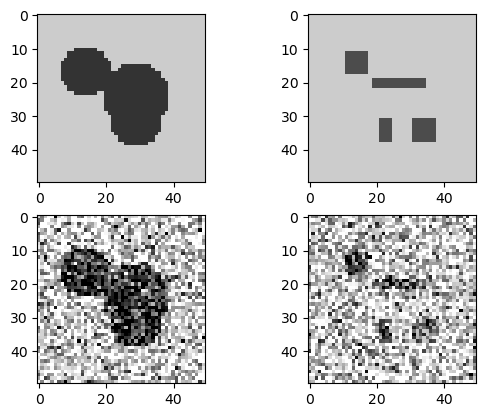

In [2]:
count = 0
m = 50
for noise = [0, 0.3], ver = 1:2
    subplot(2,2,count+=1)
    A = test_image(ver, m, noise)
    imshow(A[:,:,[1,1,1]])
end

Clearly, it appears much more difficult to identify the objects and the boundaries with a large amount of noise. The method we will implement here is particularly good at handling these cases.

### Level sets and contour plotting

The Chan-Vese method is based on the *levelset method*. A function $\Phi(x,y)$ is used to represent an interface as a zero contour, that is, the points $x,y$ where $\Phi(x,y)=0$. For example, a circle centered at $x_0,y_0$ with radius $r$ can be represented by the function

$$
\Phi(x,y) = \sqrt{(x-x_0)^2 + (y-y_0)^2} - r
$$

This is implemented in the function below, which creates a matrix $\Phi$ of given size `sz` and initializes it to values that represent a large circle.

In [3]:
function initial_value(sz)
    m,n = sz
    Φ = [sqrt((i - m/2)^2 + (j - n/2)^2) - 0.4n for i = 1:m, j = 1:n]
end

initial_value (generic function with 1 method)

The `contour` function can be used to plot the zero contour for this matrix $\Phi$:

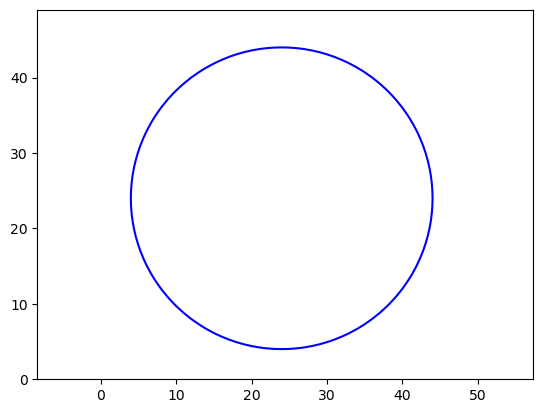

In [4]:
Φ = initial_value([50,50])
contour(Φ, [0.0], colors="b")
axis("equal");

### Algorithm

The segmentation method is based on starting from an initial matrix $\Phi$, and evolving the interface using the expressions below. With certain assumptions on the image matrix $A$, the zero contour $\Phi(x,y)=0$ will align with the boundaries of the objects in the image.

First, we define so-called smoothed Heaviside and delta functions:

$$
\begin{align*}
H(t) &= \frac12 \left(1 + \frac{2}{\pi} \arctan(t)\right) \\
\delta(t) &= \frac{d}{dt}H(t) = \frac{1}{\pi(t^2+1)}
\end{align*}
$$

For an image matrix $A$ and a levelset matrix $\Phi$, both of size $m$-by-$n$, we define the following scalars:

$$
\begin{align*}
c_1 &= \frac{\sum_{i=1}^m \sum_{j=1}^n A_{ij} H(\Phi_{ij})}
            {\sum_{i=1}^m \sum_{j=1}^n H(\Phi_{ij})} \\
c_2 &= \frac{\sum_{i=1}^m \sum_{j=1}^n A_{ij} (1 - H(\Phi_{ij}))}
            {\sum_{i=1}^m \sum_{j=1}^n (1 - H(\Phi_{ij}))}
\end{align*}
$$

Next we define an *update matrix* $\Delta \Phi$ of size $m$-by-$n$ with the following entries:

$$
\Delta\Phi_{ij} =
100\delta(\Phi_{ij})\left(0.2\kappa_{ij} - (A_{ij} - c_1)^2 + (A_{ij} - c_2)^2\right)
$$

Here, the curvature $\kappa_{ij}$ is defined by the following expressions:

$$
\begin{align*}
\Phi^{xx}_{ij} &= \Phi_{i+1,j} - 2\Phi_{ij} + \Phi_{i-1,j} \\
\Phi^{yy}_{ij} &= \Phi_{i,j+1} - 2\Phi_{ij} + \Phi_{i,j-1} \\
\Phi^{xy}_{ij} &= (\Phi_{i+1,j+1} - \Phi_{i-1,j+1} - \Phi_{i+1,j-1} + \Phi_{i-1,j-1}) / 4 \\
\Phi^{x}_{ij} &= (\Phi_{i+1,j} - \Phi_{i-1,j}) / 2 \\
\Phi^{y}_{ij} &= (\Phi_{i,j+1} - \Phi_{i,j-1}) / 2 \\
\kappa^0_{ij} &= \frac{\Phi^{xx}_{ij}(\Phi^{y}_{ij})^2 - 2\Phi^{x}_{ij}\Phi^{y}_{ij}\Phi^{xy}_{ij}
+ \Phi^{yy}_{ij}(\Phi^{x}_{ij})^2}{((\Phi^{x}_{ij})^2 + (\Phi^{y}_{ij})^2)^{3/2} + 10^{-6}} \\
\kappa_{ij} &= \max(\min(\kappa^0_{ij}, 5), -5)
\end{align*}
$$

Finally, the algorithm performs the following steps iteratively:

* Compute $c_1,c_2$
* Compute the update matrix $\Delta\Phi$
* Update $\Phi \rightarrow \Phi + \Delta\Phi$
* Repeat until $\max_{ij} |\Delta\Phi_{ij}| < 2\cdot 10^{-2}$

### Establish A type hierarchy for stencil operations

Loop over all the (internal) image pixels, apply some function to a *local* 3-by-3 submatrix around each pixel, which determines the new filtered image pixel value. This structure is also called a *stencil operation*, and the function that maps a 3-by-3 matrix to a value is called *the stencil*.

To implement this using a Julia type hierarchy, we will first define an abstract stencil type:

In [5]:
abstract type AbstractStencil end

We can then define *subtypes* for the actual stencils, e.g. for the mean filter:

In [6]:
abstract type AverageStencil <: AbstractStencil end

This allows us to define functions that are different depending on the subtype, but still write general functions that can operate on any stencil of subtype `AbstractStencil`. For example, the average stencil is defined by the following function on each 3-by-3 submatrix:

In [7]:
apply_to_3x3(s::Type{AverageStencil}, A33) = sum(A33) / length(A33)   # Average of the 9 pixels

apply_to_3x3 (generic function with 1 method)

Other functions can now be written in a way that accepts any stencil, or more precisely
any subtype of `AbstractStencil`. The following function demonstrates the syntax for doing
this, note how the stencil `s` is passed to a function `apply_stencil` that you will implement next.

In [8]:
function stencil_demo(s::Type{<:AbstractStencil})
    count = 0
    plot_next(A) = subplot(1,4,count+=1), imshow(A[:,:,[1,1,1]])
    for noise = [0, 0.3]
        A = test_image(1, 50, noise)
        plot_next(A)
        plot_next(apply_stencil(s,A))
    end
end

stencil_demo (generic function with 1 method)

##Complete the `apply_stencil` function below, which applies the stencil `s` on the image `A` and returns the resulting image.

In [9]:
function apply_stencil(s::Type{<:AbstractStencil}, A)
    B = 0*A
    for i = 2:size(A,1)-1, j = 2:size(A,2)-1
        B[i,j] = apply_to_3x3(s,A[i-1:i+1, j-1:j+1])
    end
    return B
end

apply_stencil (generic function with 1 method)

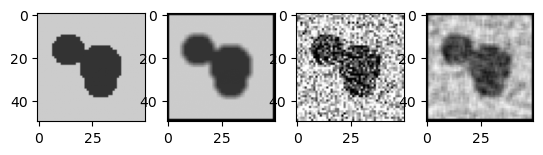

In [10]:
# Test code
stencil_demo(AverageStencil)

#Similarly, define a new subtype `EdgeStencil` which applies the same operation as `maxabsgradfilter` in the lecture notes.

In [11]:
abstract type EdgeStencil<: AbstractStencil end
apply_to_3x3(s::Type{EdgeStencil}, A33) = max(abs(A33[3,2] - A33[1,2]), abs(A33[2,3] - A33[2,1]))

apply_to_3x3 (generic function with 2 methods)

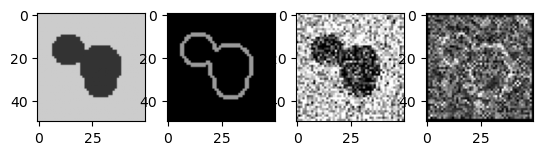

In [12]:
# Test code
stencil_demo(EdgeStencil)

Note that with the high level of noise, the edge detection essentially cannot identify the object in the image. The goal of the rest of this problem set is to implement the better levelset segmentation algorithm.

###  Utilities

Note that the curvature $\kappa$ is also a (more complicated) stencil operation of the same form as the
previous ones.

Define a new subtype `KappaStencil` which implements this function.

In [13]:
abstract type KappaStencil <: AbstractStencil end
function apply_to_3x3(s::Type{KappaStencil}, A33)
    j = 2
    i = 2
    Φ_xx_ij = A33[i+1,j] - 2A33[i,j] + A33[i-1,j]
    Φ_yy_ij = A33[i,j+1] - 2A33[i,j] + A33[i,j-1]
    Φ_xy_ij = (A33[i+1,j+1] - A33[i-1,j+1] - A33[i+1,j-1] + A33[i-1,j-1])/4
    Φ_x_ij = (A33[i+1,j] - A33[i-1,j])/2
    Φ_y_ij = (A33[i,j+1] - A33[i,j-1])/2
    k_0_ij = ((Φ_xx_ij * (Φ_y_ij^2)) - 2*(Φ_xy_ij*Φ_x_ij*Φ_y_ij) + (Φ_yy_ij*(Φ_x_ij)^2))/(((Φ_x_ij^2) + (Φ_y_ij^2))^(3/2) + 10^(-6))
    k_ij = max(min(k_0_ij,5),-5)
    return k_ij
end

apply_to_3x3 (generic function with 3 methods)

## Implement the functions `H(t)` and `δ(t)`.

In [14]:
function H(t)
    return (1/2)*(1 + (2/pi)*atan(t))
end

function δ(t)
    return 1/(pi*(t^2+1))
end

δ (generic function with 1 method)

##Implement a function `coefficients(Φ, A)` which computes and returns $c_1,c_2$
for input matrices $\Phi$ and $A$.

In [15]:
function coefficients(Φ, A)
    c1_numerator = 0
    c1_denominator = 0
    c2_numerator = 0
    c2_denominator = 0
    operation_holder_for_c1 = [[c1_numerator += (A[i,j]*H(Φ[i,j])), c1_denominator += (H(Φ[i,j]))] for i = 1:size(A,1),j = 1:size(A,2)]
    operation_holder_for_c2 = [[c2_numerator += (A[i,j]*(1 - H(Φ[i,j]))), c2_denominator += (1 - H(Φ[i,j]))] for i = 1:size(A,1),j=1:size(A,2)]
    
    return (c1_numerator/c1_denominator), (c2_numerator/c2_denominator)
end

coefficients (generic function with 1 method)

##Implement a function `update(Φ, A)` which computes and returns the update matrix $\Delta\Phi$ for
input matrices $\Phi$ and $A$ (using the functions implemented above for computing $c_1,c_2$ and $\kappa$).

In [16]:
function update(Φ, A)
    ΔΦ = zeros(size(A,1),size(A,2))
    c1,c2 = coefficients(Φ, A)
    k_i_j = apply_stencil(KappaStencil,Φ)
    operation_holder_for_Delta = [ΔΦ[i,j] = 100*δ(Φ[i,j])*((2/10)*k_i_j[i,j] - ((A[i,j]-c1)^2) + ((A[i,j]-c2)^2)) for i = 2:size(A,1)-1,j = 2:size(A,2)-1]
    return ΔΦ
end

update (generic function with 1 method)

### Final Image Segmentation function

`image_segment(A; maxiter=100000)` which implements the overall algorithm, more precisely:

The function finally returns $\Phi$ (whether it terminated early or not).

In [17]:
function image_segment(A; maxiter=100000)
    Φ = initial_value(size(A))
    count = 0
    while count <= maxiter
        update_instance = update(Φ,A)
        Φ += update_instance
        if maximum(abs.(update_instance)) < (2*10^(-2))
            break
        end
        count += 1
    end
    return Φ
end

image_segment (generic function with 1 method)

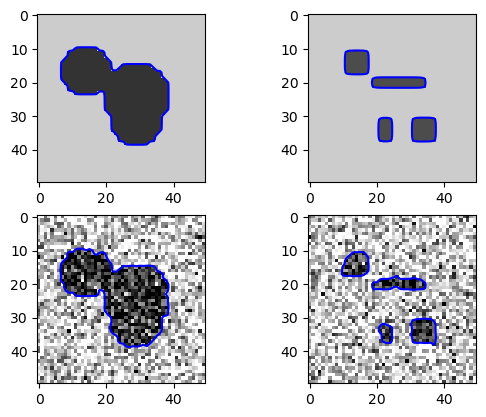

In [18]:
# Test code:
count = 0
for noise = [0, 0.3], ver = 1:2
    subplot(2,2,count+=1)
    A = test_image(ver, 50, noise)
    Φ = image_segment(A)
    imshow(A[:,:,[1,1,1]])
    contour(Φ, [0.0], colors="b")
end